# Apresentação:

A [$\text{regressão de poisson}$](https://en.wikipedia.org/wiki/Poisson_regression) é um dos tipos de [$\small \text {Modelos Lineares Generalizados}$](https://pt.wikipedia.org/wiki/Modelo_linear_generalizado) comumente apresentado no caso de regressão que trate de uma contagem, ou seja, $Y \in \mathbb{N}$. (Aqui estou considerando $0 \in \mathbb{N}$). Sabemos que o $\small \text{modelo poisson}$ faz faz parte da $\small \text{família exponencial}$, que no momento atual do curso, é um requisito para a utilização competênte de **GLM**'s.

## Distribuição da Poisson:

$$f_Y(y|\lambda) = \frac{e^{-\lambda}\lambda^y}{y!}\ \mathbb{I}_{(0,+\infty)}(y)$$

Onde,

$\text{E}[Y] = \text{var}(Y) = \lambda$

## Dados do Estudo:

Vamos analisar um conjunto de dados que contém contagens dos cânceres de pele não-melanoma diagnosticados entre mulheres nas cidades de Dallas e Minneapolis no período de um ano. Essas contagens são agrupadas por faixa etária e cidade. Como a base de dados é pequena, ela será criada no próprio R. A descrição completa das variáveis da base se dá a seguir:

* casos: número de casos de mulheres diagnosticadas com cancêr de pele no período de um ano, por cidade e faixa etária.

* pop: tamanho da população de mulheres diagnosticadas com cancêr de pele no período de um ano, por cidade e faixa etária.

* cidade: Dallas e Minneapolis - cidades contempladas no estudo.

* faixa: faixas etárias contempladas no estudo.

In [68]:
# Instalando a lib de gráficos:
library(ggplot2)

In [69]:
# Dataframe:
dados <- data.frame(casos = c(1, 16, 30, 71, 102, 130, 133, 40, 4, 38, 119, 221, 259, 310, 226, 65),
                    pop = c(172675, 123065, 96216, 92051, 72159, 54722, 32185, 8328, 181343, 146207, 121374, 111353, 83004, 55932, 29007, 7583),
                    cidade = factor(rep(c("Minneapolis", "Dallas"), each =8)),
                    faixa = factor(rep(c("15_24","25_34","35_44","45_54","55_64","65_74","75_84","85+"), 2)));dados

casos,pop,cidade,faixa
<dbl>,<dbl>,<fct>,<fct>
1,172675,Minneapolis,15_24
16,123065,Minneapolis,25_34
30,96216,Minneapolis,35_44
71,92051,Minneapolis,45_54
102,72159,Minneapolis,55_64
130,54722,Minneapolis,65_74
133,32185,Minneapolis,75_84
40,8328,Minneapolis,85+
4,181343,Dallas,15_24


In [70]:
# Verificando Dimensão dos dados:
dimension <- dim(dados)

print(sprintf("Dimensão: %d linhas, %d colunas",dimension[1],dimension[2]))

[1] "Dimensão: 16 linhas, 4 colunas"


In [71]:
# Avaliando Estrutura dos dados:
str(dados)

'data.frame':	16 obs. of  4 variables:
 $ casos : num  1 16 30 71 102 130 133 40 4 38 ...
 $ pop   : num  172675 123065 96216 92051 72159 ...
 $ cidade: Factor w/ 2 levels "Dallas","Minneapolis": 2 2 2 2 2 2 2 2 1 1 ...
 $ faixa : Factor w/ 8 levels "15_24","25_34",..: 1 2 3 4 5 6 7 8 1 2 ...


# Análise Exploratória:

A análise exploratório dos dados é uma etapa fundamental para o entendimento adequado dos dados e não se é possível a escolha adequada dos dados sem o entendimento dos dados. Aqui, sendo um exercício, já sabemos qual o modelo vamos implementar, já temos controle de circuntâncias, caracteristicas e processos que, no mundo real, só passaríamos a ter conhecimento nessa etapa.

In [72]:
attach(dados)

The following objects are masked from dados (pos = 4):

    casos, cidade, faixa, pop




A função `attach()` é usada para acessar as variáveis ​​presentes na estrutura de dados sem chamar a estrutura de dados. É uma espécie de indexação do variáveis do dataframe.

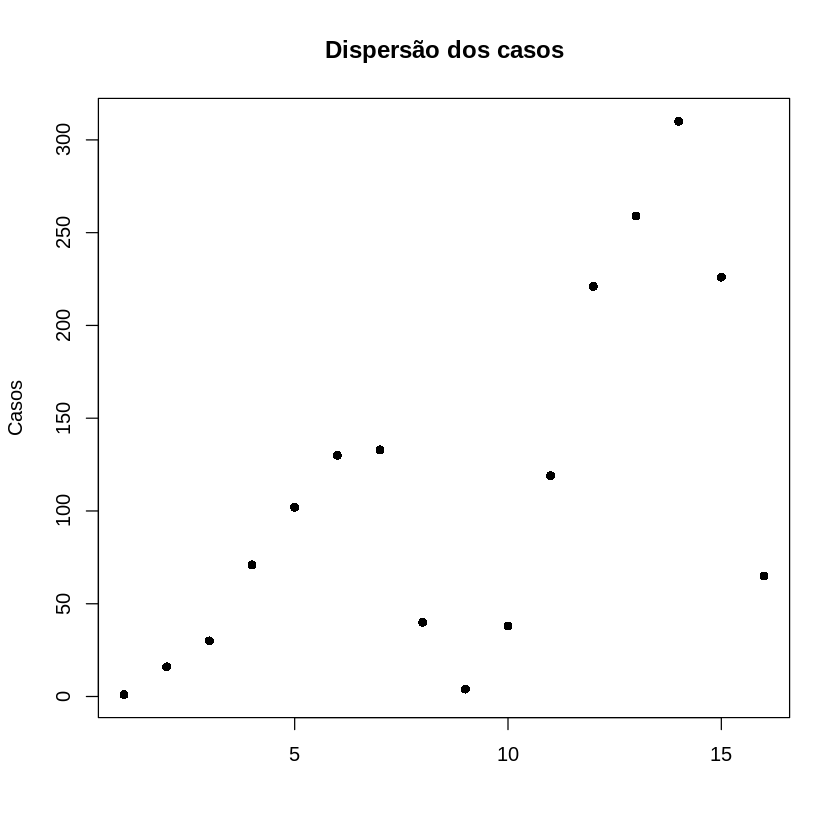

In [73]:
# Analisando dispersão de casos.
plot(casos, pch=16, ylab="Casos",xlab="",main="Dispersão dos casos")

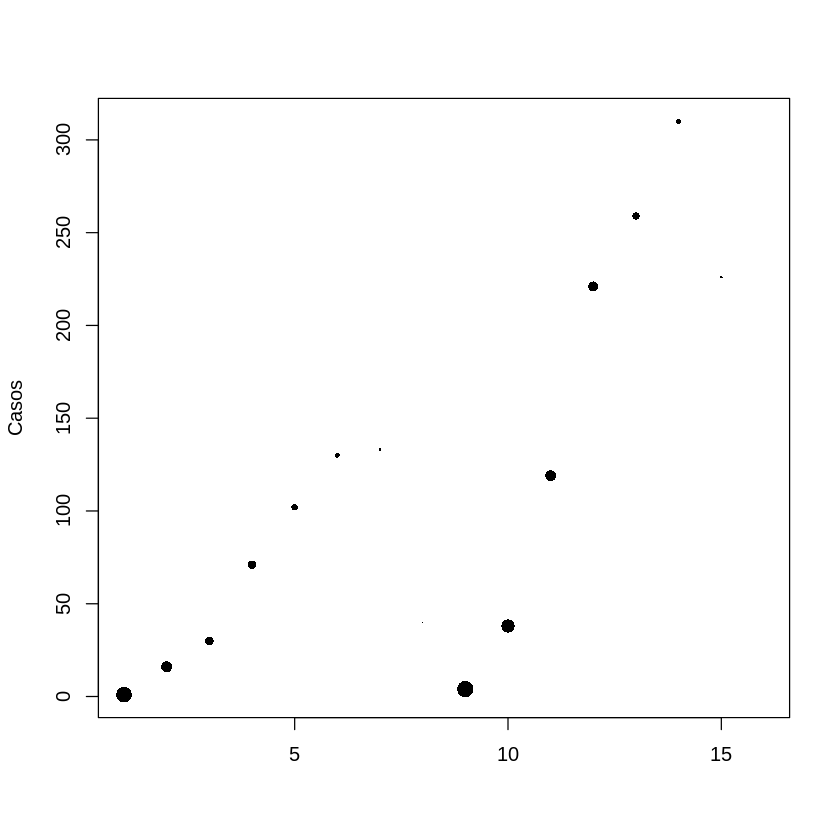

In [74]:
plot(casos, cex = 0.00001*pop, pch = 16, ylab = "Casos", xlab = "")

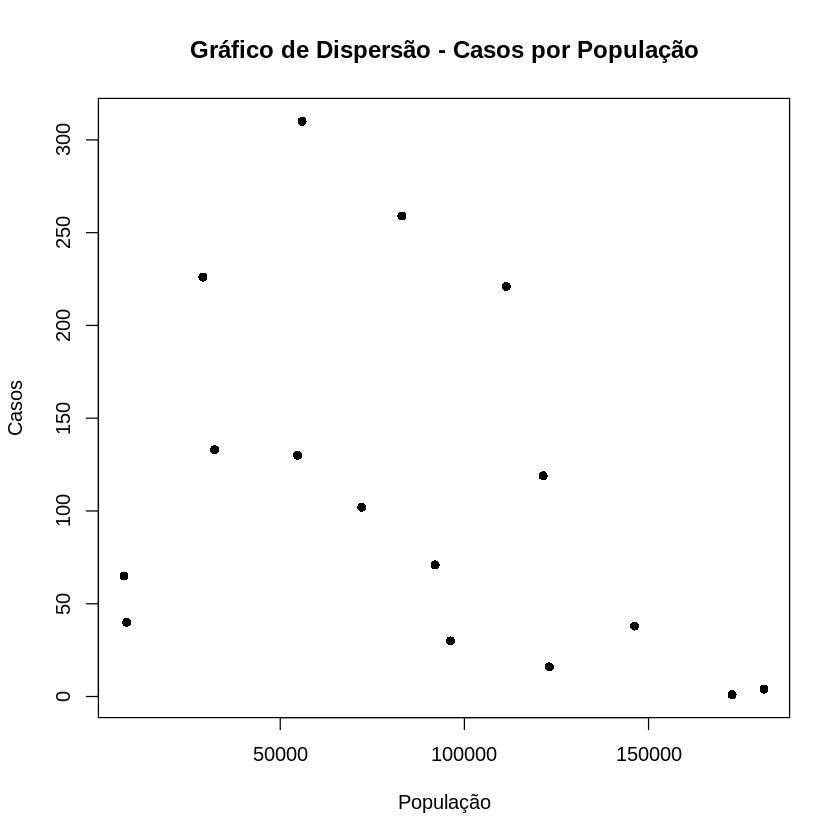

In [75]:
# Analisando casos por população:
plot(pop, casos, pch = 16, ylab = "Casos", xlab = "População", main="Gráfico de Dispersão - Casos por População")

In [76]:
# Checando estatísticas descritivas:
casos_mean <- mean(casos)
casos_var <- var(casos)

print(sprintf("Média = %.3f, Variância = %.3f",casos_mean,casos_var))

[1] "Média = 110.312, Variância = 9402.229"


Por definição o $\small \text{modelo Poisson}$, como já dito na apresentação, tem $\text{E}[Y] = \text{var}(Y) = \lambda$, porém note que a temos a variância muito grande. Vamos ver uma solução para isso.

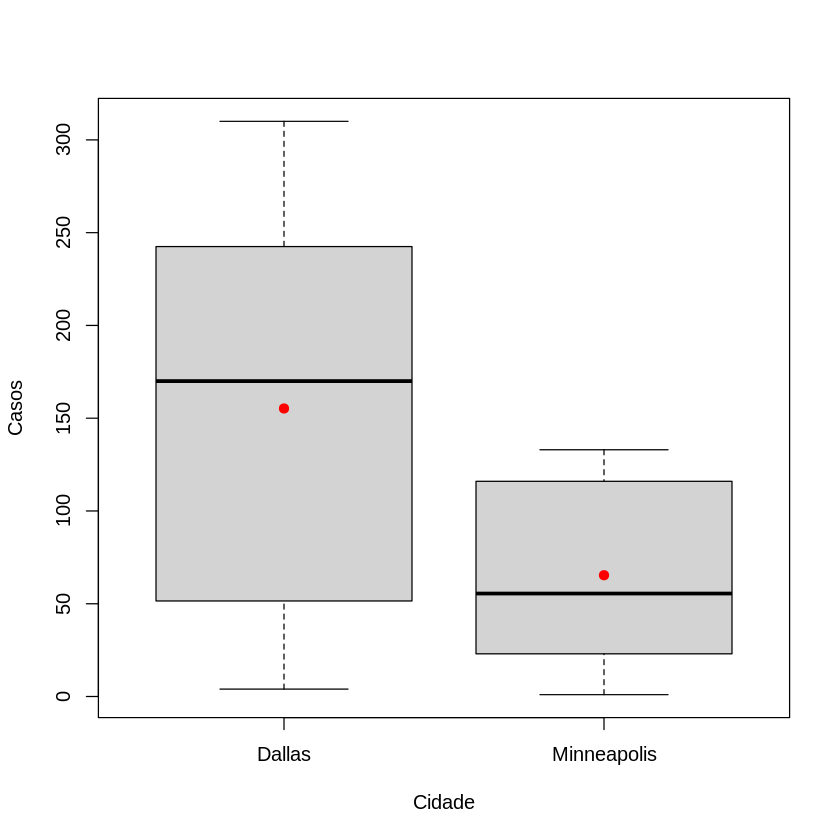

In [77]:
# Médias:
minneapolis_mean <- mean(subset(dados, cidade == "Minneapolis")$casos)
dallas_mean <- mean(subset(dados, cidade == "Dallas")$casos)
medias <- c(dallas_mean,minneapolis_mean)

# Analisando o número de casos versus covariáveis
boxplot(casos ~ cidade, ylab = "Casos", xlab = "Cidade")
points(1:length(medias), medias, col = "red", pch = 19)

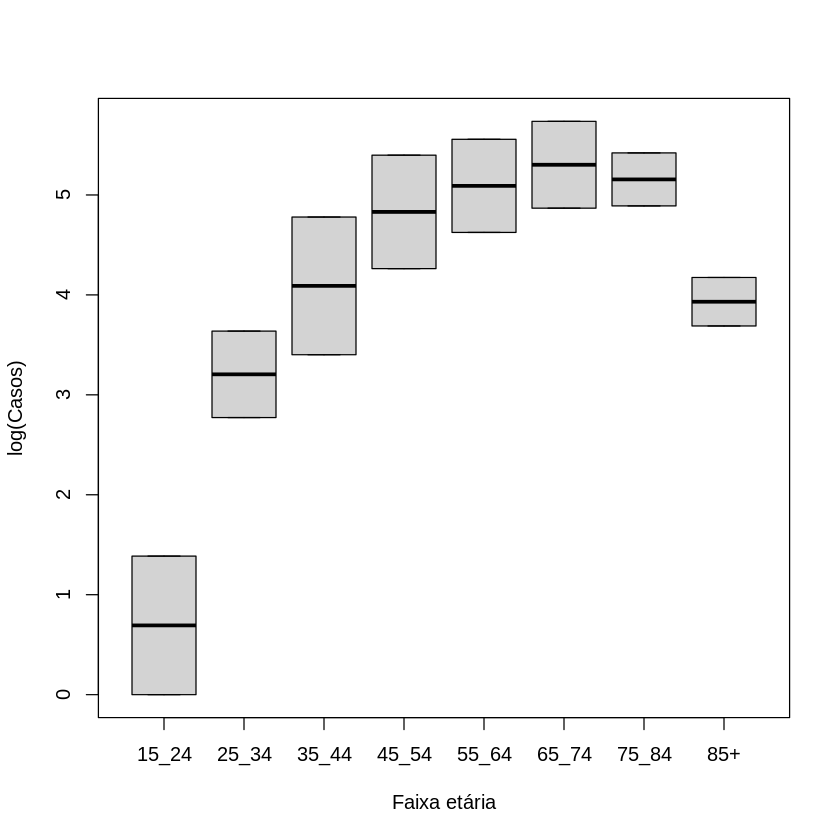

In [78]:
boxplot(log(casos) ~ faixa, ylab = "log(Casos)", xlab = "Faixa etária")

# Construição dos Modelos:

No processo de construção do modelo, é normal criar vários ajustes para testar processos e métodos de modelagem distintos com o intuito de elaborar a melhor modelagem. Aqui vamos ajustar alguns modelos e checar qual é o melhor.

## Poisson - Família Expoenencial:

Como já falamos, podemos escolher a nossa **função de ligação** da família expoenencial da distribuição. Deste modo, temos que:

$$f_y(y) = \frac{1}{\prod{y!}}exp\left\{\sum_{i=1}^ny\log{(\lambda)}-n\lambda\right\}$$

Ou seja, podemos usar aqui transformação logarítimica como nossa **função de ligação**. Que foi o que foi feito, como vemos nos parâmetros da função `glm`.

In [79]:
ajuste0 <- glm(casos ~ cidade + faixa + offset(log(pop)), family = poisson(link = "log"), data = dados)
summary(ajuste0)


Call:
glm(formula = casos ~ cidade + faixa + offset(log(pop)), family = poisson(link = "log"), 
    data = dados)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -10.8537     0.4475 -24.255  < 2e-16 ***
cidadeMinneapolis  -0.8039     0.0522 -15.399  < 2e-16 ***
faixa25_34          2.6302     0.4675   5.627 1.84e-08 ***
faixa35_44          3.8474     0.4547   8.462  < 2e-16 ***
faixa45_54          4.5952     0.4510  10.188  < 2e-16 ***
faixa55_64          5.0873     0.4503  11.298  < 2e-16 ***
faixa65_74          5.6454     0.4497  12.552  < 2e-16 ***
faixa75_84          6.0585     0.4503  13.454  < 2e-16 ***
faixa85+            6.1742     0.4577  13.488  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2789.6810  on 15  degrees of freedom
Residual deviance:    8.2585  on  7  degrees of freedom
AIC: 120.5

Number of Fisher Scoring iterat

In [80]:
for (i in range(length(df))){
  print(exp(ajuste0$coefficients[i]))
  }

 (Intercept) 
1.933271e-05 
 (Intercept) 
1.933271e-05 


In [81]:
ajuste_cf <- glm(casos ~ cidade + faixa, offset = log(pop), family = poisson(link = "log"), data = dados)
summary(ajuste_cf)


Call:
glm(formula = casos ~ cidade + faixa, family = poisson(link = "log"), 
    data = dados, offset = log(pop))

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -10.8537     0.4475 -24.255  < 2e-16 ***
cidadeMinneapolis  -0.8039     0.0522 -15.399  < 2e-16 ***
faixa25_34          2.6302     0.4675   5.627 1.84e-08 ***
faixa35_44          3.8474     0.4547   8.462  < 2e-16 ***
faixa45_54          4.5952     0.4510  10.188  < 2e-16 ***
faixa55_64          5.0873     0.4503  11.298  < 2e-16 ***
faixa65_74          5.6454     0.4497  12.552  < 2e-16 ***
faixa75_84          6.0585     0.4503  13.454  < 2e-16 ***
faixa85+            6.1742     0.4577  13.488  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2789.6810  on 15  degrees of freedom
Residual deviance:    8.2585  on  7  degrees of freedom
AIC: 120.5

Number of Fisher Scoring iterat

In [82]:
for (i in range(length(df))){
  print(exp(ajuste_cf$coefficients[i]))
  }

 (Intercept) 
1.933271e-05 
 (Intercept) 
1.933271e-05 


In [83]:
ajuste_c <- glm(casos ~ cidade + offset(log(pop)), family = poisson(link ="log"), data = dados)
summary(ajuste_c)


Call:
glm(formula = casos ~ cidade + offset(log(pop)), family = poisson(link = "log"), 
    data = dados)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -6.38424    0.02838 -224.99   <2e-16 ***
cidadeMinneapolis -0.74306    0.05213  -14.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2789.7  on 15  degrees of freedom
Residual deviance: 2569.1  on 14  degrees of freedom
AIC: 2667.4

Number of Fisher Scoring iterations: 6


In [84]:
for (i in range(length(df))){
  print(exp(ajuste_c$coefficients[i]))
  }

(Intercept) 
0.001687952 
(Intercept) 
0.001687952 


In [85]:
ajuste_f <- glm(casos ~ faixa + offset(log(pop)), family = poisson(link = "log"), data = dados)

summary(ajuste_f)


Call:
glm(formula = casos ~ faixa + offset(log(pop)), family = poisson(link = "log"), 
    data = dados)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.1677     0.4472 -24.973  < 2e-16 ***
faixa25_34    2.6532     0.4674   5.676 1.38e-08 ***
faixa35_44    3.8812     0.4546   8.537  < 2e-16 ***
faixa45_54    4.6215     0.4510  10.247  < 2e-16 ***
faixa55_64    5.1043     0.4503  11.336  < 2e-16 ***
faixa65_74    5.6403     0.4497  12.541  < 2e-16 ***
faixa75_84    6.0292     0.4503  13.389  < 2e-16 ***
faixa85+      6.1469     0.4577  13.429  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2789.68  on 15  degrees of freedom
Residual deviance:  266.74  on  8  degrees of freedom
AIC: 376.98

Number of Fisher Scoring iterations: 4


In [86]:
summary(ajuste_f)


Call:
glm(formula = casos ~ faixa + offset(log(pop)), family = poisson(link = "log"), 
    data = dados)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.1677     0.4472 -24.973  < 2e-16 ***
faixa25_34    2.6532     0.4674   5.676 1.38e-08 ***
faixa35_44    3.8812     0.4546   8.537  < 2e-16 ***
faixa45_54    4.6215     0.4510  10.247  < 2e-16 ***
faixa55_64    5.1043     0.4503  11.336  < 2e-16 ***
faixa65_74    5.6403     0.4497  12.541  < 2e-16 ***
faixa75_84    6.0292     0.4503  13.389  < 2e-16 ***
faixa85+      6.1469     0.4577  13.429  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2789.68  on 15  degrees of freedom
Residual deviance:  266.74  on  8  degrees of freedom
AIC: 376.98

Number of Fisher Scoring iterations: 4


## Critério de Informação de Akaike:

O **Critério de Informação de Akaike (Akaike Information Criterion - AIC)** é uma das métricas úteis para modelos com numero de regressoras diferentes. Lembrando que o AIC se obtém por,

$$\text{AIC} = 2k - \text{Ln}(\text{L})$$

Onde,

* $k$ é a quantidade de parâmetros estimados pelo modelo, note que essa defininção abarda o _intercept_ também;e
* $\text{Ln}(\text{L})$ é a log-verossimilhança do modelo, ou seja, é a nossa **função _score_**.

In [87]:
# Comparando os modelos ajustados
aic <- AIC(ajuste_cf, ajuste_c, ajuste_f)
aic <- aic[order(-aic$AIC),]

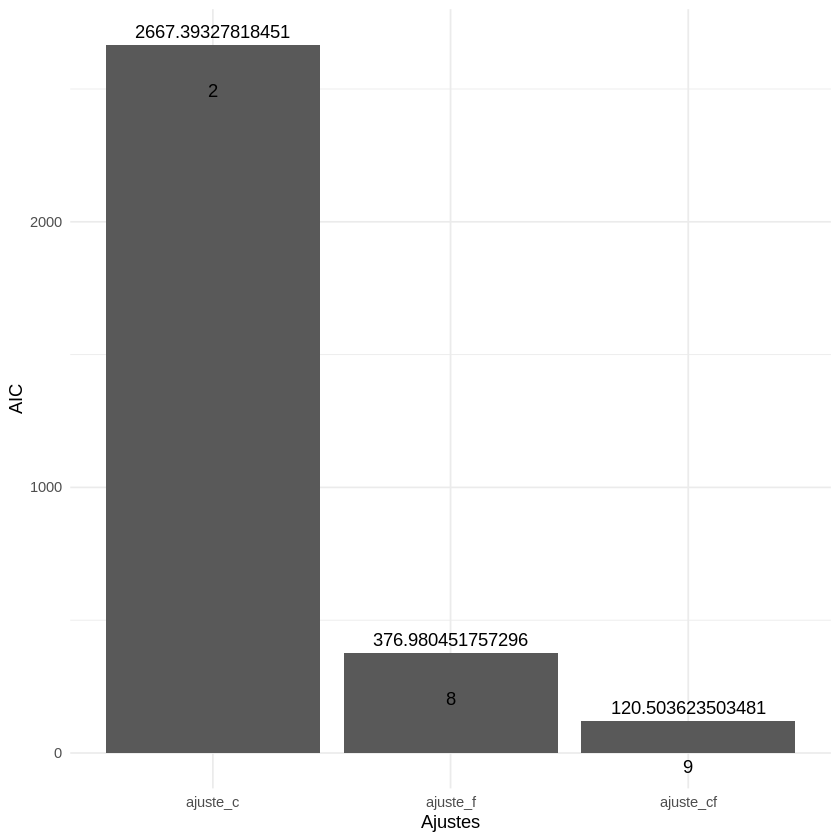

In [106]:
# Criar o barplot
ggplot(aic, aes(x = factor(rownames(aic), levels = rownames(aic)), y = AIC)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = AIC), vjust = -0.5) + # Valor da Métrica (AIC)
  geom_text(aes(label = df), vjust = 4) + # Quantidade de Parâmetros estimados
  labs(x = "Ajustes", y = "AIC") +
  theme_minimal()

Lembranod que a ideia é que o valor que tiver o **menor de AIC** é o melhor modelo segundo essa métrica, sendo assim, vemos que o ajuste_cf é a melhor modelagem em questão. Ou seja, o modelo completo, com todas as regressoras, nesse contexto é o melhor.

## Critério de Informação Bayesiano

Uma outra métrica que poderiamos utilizar com o propósito de comparar os modelos é o **Critério de Informação Bayesiano (Bayesian Information Criterion - BIC)**, cuja podemos calcular como sendo,

$$\text{BIC} = \text{Ln(n)q} - 2\text{Ln}(\hat{\text{L}})$$

O **BIC** penaliza modelos mais complexos mais fortemente do que o AIC, devido ao fator $\text{ln(n)}$. Isso porque ele busca também evitar **_overfitting_**, portanto, ele tende a selecionar modelos mais simples quando comparado ao **AIC**, especialmente com grandes tamanhos de amostra.

In [113]:
# Comparando os modelos ajustados
bic <- BIC(ajuste_cf, ajuste_c, ajuste_f)
bic <- bic[order(-bic$BIC),]

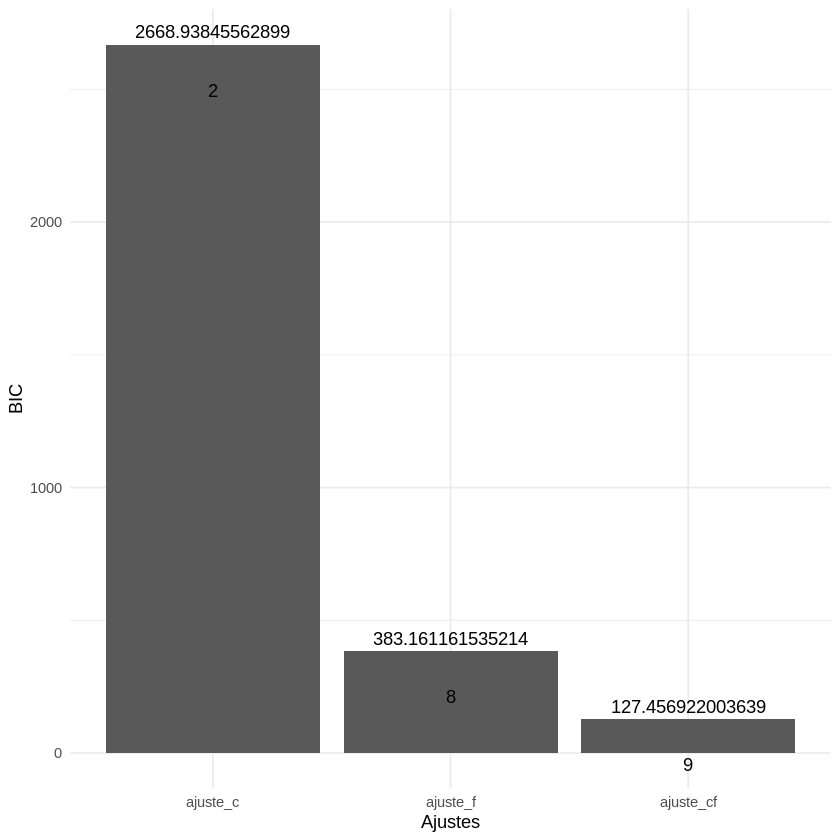

In [118]:
# Criar o barplot
ggplot(bic, aes(x = factor(rownames(bic), levels = rownames(bic)), y = BIC)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = BIC), vjust = -0.5) + # Valor da Métrica (BIC)
  geom_text(aes(label = df), vjust = 4) + # Quantidade de Parâmetros estimados
  labs(x = "Ajustes", y = "BIC") +
  theme_minimal()

Apesar de, em teoria, haver essa suposta penalização maior do **BIC** em detrimento do **AIC**, vemos que na prática, ambos as métricas de valoração de ajuste deram valores bem próximos.

## Erro Relativo:

In [145]:
erro_relativo_cf <- sum(abs((ajuste_cf$fitted.values - casos)/ajuste_cf$fitted.values))
erro_relativo_c <- sum(abs((ajuste_c$fitted.values - casos)/ajuste_c$fitted.values))
erro_relativo_f <- sum(abs((ajuste_f$fitted.values - casos)/ajuste_f$fitted.values))

erros <- c(erro_relativo_cf,erro_relativo_c,erro_relativo_f)
modelos <- c('ajuste_cf','ajuste_c','ajuste_f')

df_ErroRelativo <- data.frame(erros,models=modelos)
df_ErroRelativo <- df_ErroRelativo[order(-df_ErroRelativo$erros),]

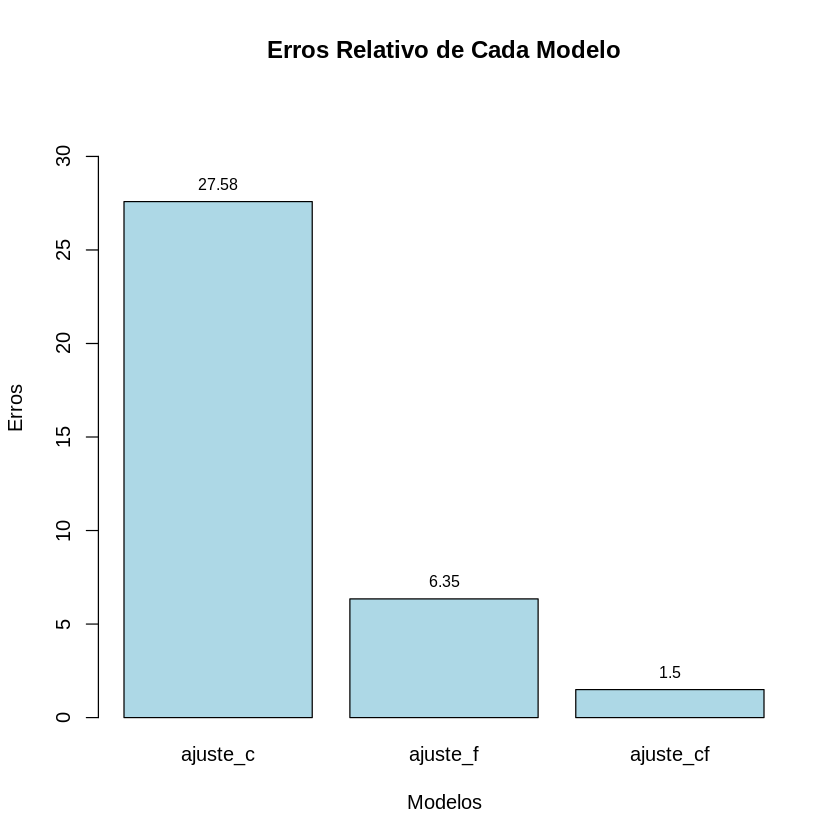

In [155]:
# Criando gráfico de barras:
text(x = barplot(height = df_ErroRelativo$erros, names.arg = df_ErroRelativo$models,
        col = "lightblue", main = "Erros Relativo de Cada Modelo",
        ylab = "Erros", xlab = "Modelos", ylim = c(0, max(df_ErroRelativo$erros) * 1.2)),
     y = df_ErroRelativo$erros,
     label = round(df_ErroRelativo$erros, 2),
     pos = 3,
     cex = 0.8,
     col = "black")

Note que a análise do **Erro Relativo** corrobora a ideia de que de fato o melhor modelo é o `ajuste_cf`.

# Interpretação dos Coeficientes:

Essa é uma etapa muito importante do processo de aprendizado estatístico. A grande vantagem de modelos de aprendizado estatístico é a interpretabilidade dos parâmetros, coisa que se perde ao utilizar arquiteturas de redes neurais.

Para o caso de **GLM**, antes de interpretarmos os coeficientes, precisamos lembrar que **há uma transformação na resposta**, ou seja, para adequar o modelo linear a uma outra família de distruibição e isso precisa ser levado em consideração na hora de interpretar os coeficientes.

In [158]:
# Extraindo coeficientes:
coef = ajuste_cf$coefficients

# Tabelando as informações:
cbind(Coef = round(coef, 5), ExpCoef = round(exp(coef), 5), ExpCoefPorc = 100*(round(exp(coef), 5) - 1))

,Coef,ExpCoef,ExpCoefPorc
(Intercept),-10.85371,0.00002,-99.998
cidadeMinneapolis,-0.80390,0.44758,-55.242
faixa25_34,2.63020,13.87656,1287.656
faixa35_44,3.84737,46.86948,4586.948
faixa45_54,4.59520,99.00761,9800.761
faixa55_64,5.08729,161.95018,16095.018
faixa65_74,5.64541,282.99024,28199.024
faixa75_84,6.05853,427.74803,42674.803
faixa85+,6.17419,480.19380,47919.380


## Transformação dos coeficientes:

Note que na construção da tabela, os coeficientes possuem $3$ abordagens diferentes. O que nos importa aqui é a coluna `ExpCoef`! A resposta é transformada pela **função de ligação**, ou seja, os coeficientes que vemos na coluna `Coef`, que é o mesmo que veriamos na função `summary`, precisam ser transformados para a escala da resposta e fazemos isso utilizando a função inversa da transformação na variável resposta, ou seja, no nosso caso, uma **função exponencial**, cuja foi feita na segunda coluna. Então, ai sim podemos interpretar os coeficientes.


## Interpretações:

* O número médio de casos de câncer de pele em mulheres de 15 à 24 anos que residem em Dallas é de 0,00002, preservadas as demais condições.

* O número médio de casos de câncer de pele em mulheres de 25 à 34 anos é 13,87 vezes o número de casos de câncer de pele em mulheres de 15 à 24 anos, preservadas as demais condições. Ou seja, espera-se um aumento de 1287,65% no número de casos de câncer de pele para mulheres de 25 à 34 anos, em comparação àquelas de 15 à 24 anos, preservadas as demais condições.

* O número médio de casos de câncer de pele em mulheres de Mineappolis é 0,44 vezes o número de casos de câncer de pele em mulheres de Dallas, preservadas as demais condições. Ou seja, espera-se 55,24% de redução no número de casos de câncer de pele para mulheres de Mineappolis, em comparação àquelas que residem em Dallas, preservadas as demais condições.

# Novas Previsões:

Vamos agora trabalhar novas previsões, dado novos dados. Vamos começar aprendendo a fazer previsões com esse modelo para a cidade de Minneapolis e faixa etária 85+.

In [166]:
# modo 1
novo_dado <- c(1, 1, 0, 0, 0, 0, 0, 0, 1)
previsão <- exp(sum(coef*novo_dado));previsão

[1] 0.004155093

Esse modo tem apenas cunho teórico, para demonstrar como o funcionamento do modelo. Note que, o vetor de `novo_dado` se refere ao valor de cada uma das regressoras.

Talvez possa parecer confuso, mas não são entradas, é uma única entrada, cuja, para cada regressora, eu tenho um valor associado. Por isso, eu obtenho apenas uma resposta.

In [167]:
# modo 2
exp(predict(ajuste_cf, newdata = data.frame(cidade = "Minneapolis", faixa ="85+", pop = 1)))

1 
0.004155093

Também tenho apenas uma entrada, mas aqui a codificação fica mais _alto nivel_. Porém, note que ainda aqui foi preciso usar a **função inversa** da **função de ligação** para retornar que a resposta venha na escala escala correta.

In [168]:
# modo 3
predict(ajuste_cf, newdata = data.frame(cidade = "Minneapolis", faixa = "85+", pop = 1), type = "response")

1 
0.004155093

Por ultimo, a mesma resposta, mas note que a saída já vem na escala da resposta, graças ao parâmetro `type`. Agora, vamos fazer previsão para as cidades de Minneapolis e Dallas para faixas etárias 15 à 24 e 85+:

In [173]:
# Novos dados:
newdata = data.frame(cidade = c("Minneapolis", "Dallas", "Minneapolis", "Dallas"),
faixa = c("15_24", "15_24", "85+", "85+"),
pop = c(1000, 1000, 1000, 1000))

# Previsão
previsao <- predict(ajuste_cf, newdata, type = "response");previsao

1          2          3          4 
0.00865295 0.01933271 4.15509270 9.28344824

# Quase-Poisson:

Por fim, lembre que a distribuição poisson assume média igual a variância, o que pode não ser verdade sempre. Para acomodar a sobredispersão dos dados, podemos fazer um ajuste **Quasi-Poisson**.

In [174]:
# Ajustando modelo:
ajuste_cf2 <- glm(casos ~ cidade + faixa, offset = log(pop), family = quasipoisson(link = "log"), data = dados)

# Sumario do Modelo:
summary(ajuste_cf2)


Call:
glm(formula = casos ~ cidade + faixa, family = quasipoisson(link = "log"), 
    data = dados, offset = log(pop))

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -10.85371    0.48217 -22.510 8.64e-08 ***
cidadeMinneapolis  -0.80390    0.05625 -14.291 1.95e-06 ***
faixa25_34          2.63020    0.50370   5.222 0.001223 ** 
faixa35_44          3.84737    0.48990   7.853 0.000103 ***
faixa45_54          4.59520    0.48599   9.455 3.09e-05 ***
faixa55_64          5.08729    0.48521  10.485 1.56e-05 ***
faixa65_74          5.64541    0.48461  11.649 7.76e-06 ***
faixa75_84          6.05853    0.48523  12.486 4.87e-06 ***
faixa85+            6.17419    0.49322  12.518 4.79e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 1.161046)

    Null deviance: 2789.6810  on 15  degrees of freedom
Residual deviance:    8.2585  on  7  degrees of freedom
AIC: NA

Number 

## Interpretação do sumário:

Notem que, os coeficientes estimados se mantêm os mesmos! O que muda, neste caso são os erros padrão (_Std. Error_) e, consequentemente, os valores da **estatística t** e seus respectivos **p-valores**.

Além disso, é fornecida uma estimativa para o **parâmetro de dispersão**, que nesse caso foi próxima de 1, **não indicando sobredispersão**. A interpretação desse valor é: condicional ao preditor linear, a variância dascontagens é 1.161046 vezes a média. No mais, nesse caso não temos um valor de AIC pois não temos uma função de **verossimilhança** associada ao modelo. Por fim, vamos fazer previsões com esse modelo.

In [177]:
pridicao_qPoisson <- exp(predict(ajuste_cf2, newdata = data.frame(cidade = "Minneapolis", faixa ="85+", pop = seq(1000, 100000, by = 10000))));pridicao_qPoisson

1          2          3          4          5          6          7 
  4.155093  45.706020  87.256947 128.807874 170.358801 211.909728 253.460655 
         8          9         10 
295.011582 336.562509 378.113436